In [48]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
# load the movies_metadata dataset. This is a blueprint code from kaggle api
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "movies_metadata.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "rounakbanik/the-movies-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/var/folders/5c/_swffsgd4xz7nw4tfsfl0pbr0000gn/T/ipykernel_52726/1823648364.py:9: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  t

/Users/alpaltug/.pyenv/versions/3.11.5/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


In [50]:
movie_titles = df['title'].tolist()

# printing the first few movie titles to verify
print("First 10 movie titles:", movie_titles[:10])

# printing the length of the movies list
print("Total number of movies:", len(movie_titles))

First 10 movie titles: ['Toy Story', 'Jumanji', 'Grumpier Old Men', 'Waiting to Exhale', 'Father of the Bride Part II', 'Heat', 'Sabrina', 'Tom and Huck', 'Sudden Death', 'GoldenEye']
Total number of movies: 45466


In [88]:
cleaned_movie_titles = [str(title) for title in movie_titles]

chars = sorted(list(set(''.join(cleaned_movie_titles))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
print(vocab_size)

block_size = 16  # predicting the next character from the past 16 chars

287


In [94]:
# build dataset

def build_dataset(words):
    X, Y = [], []
    padding_idx = stoi['.'] # Make sure this is correct based on your stoi

    for w in words:
        context = [padding_idx] * block_size
        for c in (w + '.'):
            if c not in stoi:
                print(f"DEBUG: Character '{c}' (ord={ord(c)}) not found in stoi for word '{w}'!")
                # Decide how to handle: skip, map to UNK, or raise error
                raise ValueError(f"Character '{c}' not in vocabulary.")
            idx = stoi[c]
            if idx >= vocab_size:
                continue
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(123)
random.shuffle(cleaned_movie_titles)
n1 = int(0.8*len(cleaned_movie_titles))
n2 = int(0.9*len(cleaned_movie_titles))

Xtr, Ytr = build_dataset(cleaned_movie_titles[:n1])
Xval, Yval = build_dataset(cleaned_movie_titles[n1:n2])
Xte, Yte = build_dataset(cleaned_movie_titles[n2:])

In [95]:
# define the layers of our network

# Linear1D Layer (torch's nn.Linear layer)
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**1/2  # normalize
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) 

# ---------------------------------------------------------------------------------------------------------

# Linear1D Layer (torch's nn.BATCHNORM1D layer)
class BatchNorm1d:

    def __init__(self, dims, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
         # parameters (trained with backprop)
        self.gamma = torch.ones(dims)
        self.beta = torch.zeros(dims)
        # buffers (trained with running a 'momentum' update)
        self.running_mean = torch.zeros(dims)
        self.running_var = torch.ones(dims)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdims=True)  # calculate the batch mean
            xvar = x.var(dim, keepdims=True)  # calculate the batch variance
        else:
            xmean = self.running_mean  # sample mean
            xvar = self.running_var  # sample variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# ---------------------------------------------------------------------------------------------------------

# Tanh Nonlinearity layer (torch's nn.TANH layer)

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# ---------------------------------------------------------------------------------------------------------


# Embedding Lookup table layer (torch's nn.EMBEDDING layer)

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

# ---------------------------------------------------------------------------------------------------------

# Flatten layer to concat trailing dimensions (torch's nn.FLATTEN layer)

class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

# ---------------------------------------------------------------------------------------------------------

# Flatten layer to concat trailing dimensions (torch's nn.FLATTEN layer)

class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

# ---------------------------------------------------------------------------------------------------------

# similar to torch.nn.Sequential()

class Sequential():

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return x
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [96]:
torch.manual_seed(123)

In [97]:
n_embd = 24
n_hidden = 512

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(2 * n_embd, n_hidden // 2, bias=False), BatchNorm1d(n_hidden // 2), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden // 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(2 * n_hidden, n_hidden // 2, bias=False), BatchNorm1d(n_hidden // 2), Tanh(),
    Linear(n_hidden // 2, vocab_size)
    
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

1144583


In [104]:
# optimize the weights using batches
max_steps = 200000
batch_size = 64
lossi = []
ud = []

for i in range(max_steps):

    # construct the batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)

    # calculate the loss
    loss = F.cross_entropy(logits, Yb) # input x is logits of shape (32, vocab_size), y is the targets of size (32) -> converts logits into counts and computes the cross entropy loss

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.05 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # break  # AFTER_DEBUG

      0/ 200000: 1.1975
  10000/ 200000: 1.5921
  20000/ 200000: 1.0169
  30000/ 200000: 1.3745
  40000/ 200000: 1.4908
  50000/ 200000: 1.1198
  60000/ 200000: 0.9952
  70000/ 200000: 1.3306
  80000/ 200000: 1.4683
  90000/ 200000: 1.2538
 100000/ 200000: 1.0574
 110000/ 200000: 0.9388
 120000/ 200000: 0.9299
 130000/ 200000: 0.8704
 140000/ 200000: 0.8303
 150000/ 200000: 0.6934
 160000/ 200000: 1.2947
 170000/ 200000: 0.8760
 180000/ 200000: 0.8460
 190000/ 200000: 0.8633


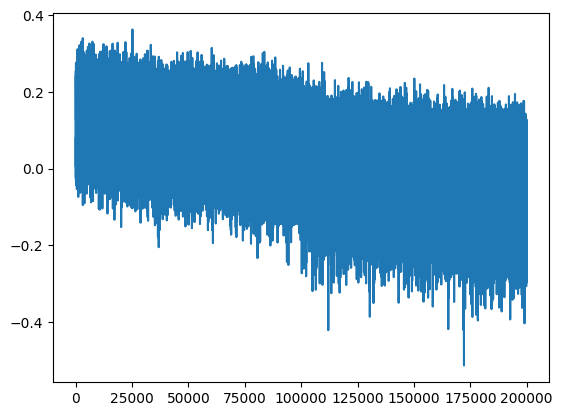

In [105]:
plt.plot(lossi)

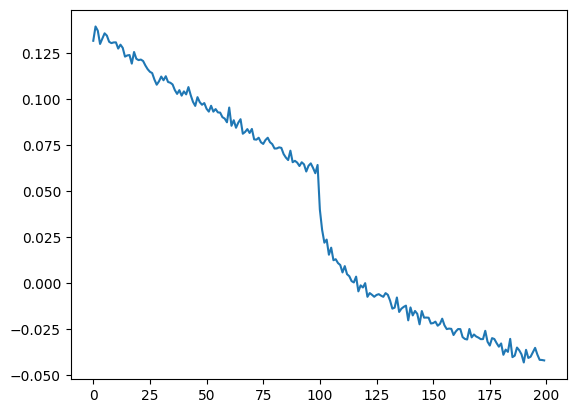

In [106]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [107]:
# we need to change the state when testing

for layer in model.layers:
    layer.training = False

In [108]:
@torch.no_grad() # this decorater disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xval, Yval),
        "train": (Xte, Yte),
    }[split]

    logits = model(x)

    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    

split_loss("train")
split_loss("val")

train 2.057239532470703
val 2.057987928390503


In [117]:
# sample from model
num_samples = 2000
out = []
for i in range(num_samples):
    context = [0] * block_size
    name = ""
    while True:
        logits = model(torch.tensor(context).unsqueeze(0)) # Add a batch dimension

        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        name += itos[idx]
        context = context[1:] + [idx]
        if idx == 0:
            out.append(name)
            break

print(out)

['The Inspector Comes at the Voes.', 'Creep Dander Part 26I.', 'Sundoment.', 'Baxter For My Song.', 'David: A Quest of Saladin.', 'Split Second.', 'Red Know.', 'Sweet Smart.', 'The Amber Death.', 'Ash Povers.', "Maliety'sigati.", '2000 Feets Fire: Sleep We Were Hart, Lady C.', 'The Perfect Roommar: Escape Hamilton.', 'Garfield.', 'Pigsty.', 'The 345 loom Free.', 'The Linguists.', 'Super Buddies.', 'Kung Fu Chot Hour.', 'The Anderson Room.', 'Tracing Rangers.', 'Scooby-Doo 2imes Outsiders.', 'One Last Zombies.', 'Camille.', 'The Steel Villad.', 'Big Girls.', 'Lost in Manhattan.', 'My Sister Mitztechens.', 'Die Saleslance.', 'My Girl.', 'Mademoiselle.', 'Tryenie & Angels.', 'The Most Beautiful.', "Mind's People from Above.", '9th Child.', 'Café a Girl in Water.', 'Speed Alien.', 'Carpet Harp.', 'Blood All-Adder.', 'Djomehbilly You Were The World Unite.', 'The Conquerors.', 'The Man of Gore Girl.', 'The Chocolate Cave Kid.', 'Born to Be Good.', 'Rough Cut.', 'Black Square.', 'Belle du Sei